In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update(
    {
        # ── Canvas size & resolution ───────────────────────────────────────────
        # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
        "figure.figsize": (12, 8),
        "figure.dpi": 200,  # crisp in-notebook / retina preview
        "savefig.dpi": 400,  # print-quality PNG/PDF
        # ── Fonts ──────────────────────────────────────────────────────────────
        "font.family": "sans-serif",
        "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
        "axes.titlesize": 24,
        # "axes.titleweight": "bold",
        "axes.labelsize": 24,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 20,
        # ── Axis & spine aesthetics ────────────────────────────────────────────
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.linewidth": 1,
        "axes.grid": True,
        "grid.color": "#E6E6E6",
        "grid.linewidth": 0.4,
        "grid.alpha": 0.8,
        # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
        "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),
        # ── Figure background ─────────────────────────────────────────────────
        "figure.facecolor": "white",
    }
)

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",  # slightly larger fonts for presentations / papers
    style="whitegrid",  # grid only on y-axis (good for histograms)
    palette="Set2",  # matches the rcParams colour cycle
)


# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=True, **savefig_kwargs)


# 4.  Colour constants for this project (optional convenience)
COL_RAW = "#1f77b4"  # e.g. unweighted sample
COL_WEIGHTED = "#d62728"  # weighted sample
COL_REF = "0.35"  # census reference (neutral grey)

In [3]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/athletes_brain/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/athletes_brain/figures/fig2")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" / "atlases" / ATLAS / "parcels.csv", index_col=0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [5]:
metrics = ["gm_vol", "wm_vol", "csf_vol", "adc", "fa", "ad", "rd"]
distribution_metric = "qfmean"

bad_subjects = ["IN120120"]

# Load the data
data = {}
for metric in metrics:
    data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
        drop=True
    )
    # data[metric] = data[metric].drop_duplicates(subset=["subject_code", region_col], keep="last")
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})


# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_1594505/386709695.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykernel_1594505/386709695.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykernel_1594505/386709695.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
/tmp/ipykernel_1594505/386709695.py:9: DtypeWarning: Columns (16,23,24,25,26,27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{me

In [6]:
metric_cols = {metric: "volume" if "vol" in metric else distribution_metric for metric in metrics}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df

In [12]:
import pandas as pd
import numpy as np
from functools import reduce

# Assuming 'region_col' is defined globally (e.g., 'Region_Name' or 'Region_ID')
# Make sure to define it if not already:
# region_col = 'Region_ID' # Example, adapt to your actual region column name


# --- Adapted `long_to_wide` Function ---
def long_to_wide(
    long_df,
    *,
    index_cols=["subject_code", "session_id"],  # Use both for unique sessions
    columns_to_pivot=region_col,  # Your region column name
    values_col="value",
    demographic_cols=[
        "age_at_scan",
        "sex",
        "group",
        "target",
        "tiv",
    ],  # Include all relevant demographics/targets
):
    """
    Pivots a long metric table to a wide DataFrame (sessions x features),
    while preserving demographic and target columns.

    Parameters
    ----------
    long_df : pd.DataFrame
        Input DataFrame in long format with columns like index_cols, columns_to_pivot,
        values_col, and demographic_cols.
    index_cols : list of str
        Columns to use as the index for pivoting (e.g., ['Participant_ID', 'Session_ID']).
    columns_to_pivot : str
        Column containing the region names/IDs to become new columns.
    values_col : str
        Column containing the metric values.
    demographic_cols : list of str
        Other columns to preserve (demographics, target variables).

    Returns
    -------
    pd.DataFrame
        Wide-format DataFrame with (Participant_ID, Session_ID) as a multi-index,
        region values as columns (prefixed with metric type), and
        demographic/target columns.
    """
    # Ensure all index_cols and demographic_cols are in the DataFrame
    if not all(col in long_df.columns for col in index_cols + [columns_to_pivot, values_col]):
        raise ValueError(
            f"Missing essential columns for pivoting. Required: {index_cols + [columns_to_pivot, values_col]}"
        )

    # Filter demographic_cols to only those actually present in the long_df
    present_demographic_cols = [col for col in demographic_cols if col in long_df.columns]

    # Handle multiple sessions per participant if Session_ID is not explicit
    if "session_id" not in long_df.columns:
        long_df["session_id"] = long_df.groupby("Participant_ID").cumcount() + 1
        print(
            "  Warning: 'Session_ID' not found in long_df. Generated dummy Session_ID for pivoting."
        )

    # Select columns to pivot and drop duplicates for the index/demographics
    # We drop duplicates to ensure only one set of demographic/target data per session
    meta_df = long_df[index_cols + present_demographic_cols].drop_duplicates(subset=index_cols)
    meta_df = meta_df.set_index(index_cols)

    # Pivot the metric data
    wide_metric = long_df.pivot_table(
        index=index_cols, columns=columns_to_pivot, values=values_col
    )

    # Merge demographics back. Ensure column names from wide_metric are unique.
    # The columns from wide_metric are already the region names, no prefix needed here yet.
    full_wide_df = meta_df.join(
        wide_metric, how="inner"
    )  # Inner join to ensure only sessions with metric data

    # Optional: Missing value thresholding
    # These thresholds might need careful consideration in a multimodal context
    # as dropping columns from one metric might affect others later.
    # For initial combined ML, it's often better to drop NaNs at the end on the full feature set.
    # You can re-enable if you want to filter per-metric-wise first.
    # thresh_cols = int(0.8 * len(full_wide_df))
    # full_wide_df = full_wide_df.dropna(axis=1, thresh=thresh_cols)
    # thresh_rows = int(0.8 * len(wide_metric.columns)) # Assuming parcels is wide_metric.columns
    # full_wide_df = full_wide_df.dropna(axis=0, thresh=thresh_rows)

    return full_wide_df.reset_index()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
)  # RidgeClassifier for stacking meta-learner
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import GridSearchCV

# Suppress some sklearn/pd future warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# create a dictionary of models with their hyperparameters to tune

ESTIMATORS = {
    LogisticRegression: {
        "C": [1.0, 10.0, 100.0],
        "solver": ["liblinear"],  # 'liblinear' is good for small datasets
        "max_iter": [1000],
        "class_weight": ["balanced"],  # Handle class imbalance
    },
    RandomForestClassifier: {
        "n_estimators": [50, 100, 200],  # Example hyperparameter to tune
        "class_weight": ["balanced"],
        "random_state": [42],
    },
    SVC: {
        "kernel": ["linear", "rbf"],  # Example hyperparameters to tune
        "C": [1.0, 10.0],
        "probability": [True],  # Enable probability estimates for ROC AUC
        "class_weight": ["balanced"],
        "random_state": [42],
    },
    RidgeClassifier: {
        "alpha": [1.0, 10.0],  # Regularization strength
        "class_weight": ["balanced"],
        "random_state": [42],
    },
    # Add more models as needed
}


def train_and_evaluate_model(X, y, groups, model, k_features=-1, problem_type="binary", features_description="GM Volume"):
    """
    Trains and evaluates a classification model using GroupKFold cross-validation,
    ensuring all sessions from a participant are in the same fold.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix. Rows are sessions, columns are features.
    y : pd.Series
        Target variable (numerical labels). Values are 0, 1, 2...
    groups : pd.Series
        Group labels for GroupKFold (e.g., Participant_ID). Must be the same length as X and y.
    model_type : str
        Type of classifier to use ('LogisticRegression', 'RandomForest', 'SVC').
    features_description : str
        A descriptive string for the features used in this run (e.g., 'GM_vol only', 'All Metrics').
    problem_type : str
        'binary' for 2-class classification (e.g., Athlete vs. Control),
        'multiclass' for 3+ class classification (e.g., Climber, BJJ, Control).
    k_features : int
        Number of top features to select using SelectKBest (based on ANOVA F-value).
        Set to -1 to use all features (no selection).

    Returns
    -------
    dict
        A dictionary of evaluation metrics for the model.
    """
    print(
        f"\n--- Training {model}"
    )

    # Ensure y is properly aligned with X and groups after any previous filtering/dropping
    # This is a critical step to prevent indexing errors
    common_index = X.index.intersection(y.index).intersection(groups.index)
    X = X.loc[common_index]
    y = y.loc[common_index]
    groups = groups.loc[common_index]

    if X.empty or y.empty or len(y.unique()) < 2:
        print(
            f"  Skipping model training: Not enough data or classes ({len(y.unique())} unique) for classification."
        )
        return {}  # Return empty dictionary if not enough data

    # Define the classifier based on model_type
    params = ESTIMATORS.get(model)
    if params is None:
        raise ValueError(f"Model type '{model}' is not supported. Choose from {list(ESTIMATORS.keys())}.")
    params = {f"model__{key}": val for key, val in params.items()}
    # Create a pipeline: Scaling -> Feature Selection (optional) -> Model
    # SelectKBest is skipped if k_features is -1 or 0, or more features than available
    if k_features > 0 and k_features < X.shape[1]:
        pipeline = Pipeline(
            [
                ("scaler", StandardScaler()),
                ("feature_selection", SelectKBest(f_classif, k=min(k_features, X.shape[1]))),
                ("model", model),
            ]
        )
    else:  # Use all features
        pipeline = Pipeline([("scaler", StandardScaler()), ("model", model)])

    y_preds_all = []
    y_trues_all = []
    y_probas_all = []  # For ROC AUC in binary case

    # Group K-Fold Cross-Validation to ensure participants stay in one split
    gkf = GroupKFold(n_splits=5)  # 5 folds is a good starting point

    # hyperparameter tuning with GridSearchCV (optional)
    grid = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=gkf,  # Use the same GroupKFold for hyperparameter tuning
        scoring="accuracy",  # Use accuracy for tuning, can be changed based on problem_type
        n_jobs=-1,  # Use all available cores
        verbose=1,  # Show progress
    )
    # Fit the model with GridSearchCV
    print(params)
    grid.fit(X, y, groups=groups.astype("category").cat.codes)  # Ensure groups are categorical for GroupKFold
    # Use the best estimator from GridSearchCV
    pipeline = grid.best_estimator_


    # Iterate over folds
    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Skip fold if any class is missing in either train or test set
        if len(y_train.unique()) < 2 or len(y_test.unique()) < 2:
            print(
                f"  Skipping fold {fold_idx+1}: Not enough classes in train or test split. (Train unique: {y_train.unique()}, Test unique: {y_test.unique()})"
            )
            continue

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        y_preds_all.extend(y_pred)
        y_trues_all.extend(y_test)

        if problem_type == "binary" and hasattr(
            model, "predict_proba"
        ):  # Check if model outputs probabilities
            y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability of the positive class (1)
            y_probas_all.extend(y_proba)
        elif problem_type == "binary" and hasattr(
            model, "decision_function"
        ):  # For SVC without probability=True
            y_proba = pipeline.decision_function(X_test)  # Decision function values
            # For ROC AUC with RidgeClassifier, you'd need to convert scores to probabilities
            # e.g., using sigmoid or isotonic regression on calibrated probabilities (more advanced)
            # For simplicity, we'll note if probas are not available.
            y_probas_all.extend(y_proba)

    # Calculate overall metrics based on all aggregated predictions
    metrics = {}
    if not y_trues_all:  # If all folds were skipped
        print("  No folds processed successfully to calculate metrics.")
        return metrics

    metrics["accuracy"] = accuracy_score(y_trues_all, y_preds_all)

    if problem_type == "binary":
        metrics["precision"] = precision_score(y_trues_all, y_preds_all, zero_division=0)
        metrics["recall"] = recall_score(y_trues_all, y_preds_all, zero_division=0)
        metrics["f1_score"] = f1_score(y_trues_all, y_preds_all, zero_division=0)

        if y_probas_all and (
            len(np.unique(y_trues_all)) > 1
        ):  # Check if there are probabilities and at least two classes
            try:
                # Ensure probabilities are floats for roc_auc_score
                metrics["roc_auc"] = roc_auc_score(
                    y_trues_all, np.array(y_probas_all).astype(float)
                )
            except ValueError:
                metrics["roc_auc"] = np.nan
                print(
                    "  Warning: ROC AUC cannot be calculated (problem with probabilities or single class in true labels)."
                )
        else:
            metrics["roc_auc"] = np.nan
            print(
                "  Warning: ROC AUC cannot be calculated (probabilities not available or single class in true labels)."
            )

    else:  # Multiclass
        metrics["precision_macro"] = precision_score(
            y_trues_all, y_preds_all, average="macro", zero_division=0
        )
        metrics["recall_macro"] = recall_score(
            y_trues_all, y_preds_all, average="macro", zero_division=0
        )
        metrics["f1_score_macro"] = f1_score(
            y_trues_all, y_preds_all, average="macro", zero_division=0
        )
        # For multiclass, roc_auc can be calculated with 'ovo' or 'ovr' strategies if probabilities are available
        # This is more complex and often accuracy/f1_macro are sufficient for initial assessment.
        # metrics['classification_report'] = classification_report(y_trues_all, y_preds_all, output_dict=True, zero_division=0) # If you want detailed per-class metrics

    print(f"  Overall Metrics for {features_description}:")
    for metric, value in metrics.items():
        if isinstance(value, float):
            print(f"    {metric}: {value:.3f}")

    return metrics


m = train_and_evaluate_model(X=data["gm_vol"].drop(columns=["subject_code", "session_id"]),
                             y=data["gm_vol"]["target"],
                             groups=data["gm_vol"]["subject_code"],
                             model=LogisticRegression,
                             k_features=-1,
                             problem_type="binary",
                             features_description="GM Volume")


--- Training <class 'sklearn.linear_model._logistic.LogisticRegression'>
{'model__C': [1.0, 10.0, 100.0], 'model__solver': ['liblinear'], 'model__max_iter': [1000], 'model__class_weight': ['balanced']} 0          AGN11
1          AGN11
2          AGN11
3          AGN11
4          AGN11
           ...  
847159    FTNL23
847160    FTNL23
847161    FTNL23
847162    FTNL23
847163    FTNL23
Name: subject_code, Length: 846710, dtype: object
Fitting 5 folds for each of 3 candidates, totalling 15 fits


TypeError: BaseEstimator.get_params() missing 1 required positional argument: 'self'

In [ ]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation


atlas_img = nib.load(nifti_matlab)

# ---------------------------------------------------------------------
# 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
# ---------------------------------------------------------------------
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]


# ---------------------------------------------------------------------
# 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
# ---------------------------------------------------------------------
# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation("schaefer")

In [ ]:
# ---------------------------------------------------------------------
# 4.  MAP REGION IDs → METRIC VALUES
#     vertices with label 0 (background) → NaN so they render transparent
# ---------------------------------------------------------------------
p_threshold = 0.05
value_threshold = 0

value_map = {}
value_map_subcortex = {"region": [], "value": [], "Hemisphere": []}

key = "gm_vol"  # or any other metric you want to visualize


# vis_df = athletes_vs_naive_results[key].copy()
vis_df = sports_vs_naive_results[climber_group_label][
    key
].copy()  # or climbers_vs_bjj_results[key].copy()
p_column = "adjusted_p_value"
value_column = "t_statistic"

value_map_lh = {}  # New: separate map for left hemisphere
value_map_rh = {}  # New: separate map for right hemisphere

for i, row in vis_df.iterrows():
    label = row[region_col]
    hemi_row = row["hemisphere"]  # Get hemisphere from your DataFrame row

    # Apply thresholds
    if (row[p_column] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
        value = row[value_column]
    else:
        value = np.nan  # Set to NaN if not significant or below value_threshold

    # Populate the correct hemisphere's value_map
    # Assuming your labels are global and you use the 'hemisphere' column to distinguish
    # If your Schaefer labels are already separated by hemi (e.g., 1-200 for LH, 201-400 for RH)
    # then you might only need to check the label range and not the 'hemisphere' column.
    # For Schaefer, the labels usually run 1-N for LH and N+1 - 2N for RH
    if "schaefer" in ATLAS:
        if label > int(ATLAS.split("_")[1]):
            value_map_subcortex["region"].append(label)
            value_map_subcortex["value"].append(value)
            value_map_subcortex["Hemisphere"].append(row["hemisphere"])
        else:
            if hemi_row == "L":
                value_map_lh[label] = value
            elif hemi_row == "R":
                value_map_rh[label] = value
        # Subcortex handling would go here if you were preparing for separate subcortical visualization
        # else: # This implies it's subcortical or other non-surface region
        #     value_map_subcortex["region"].append(label)
        #     value_map_subcortex["value"].append(value)
        #     value_map_subcortex["Hemisphere"].append(row["hemisphere"])

# Vectorize mapping for left and right hemispheres separately
vec_lh = np.vectorize(lambda x: value_map_lh.get(x, np.nan))
data_lh_mapped = vec_lh(lh_parc)  # Apply LH map to LH parcellation
vec_rh = np.vectorize(lambda x: value_map_rh.get(x, np.nan))
data_rh_mapped = vec_rh(rh_parc)  # Apply RH map to RH parcellation

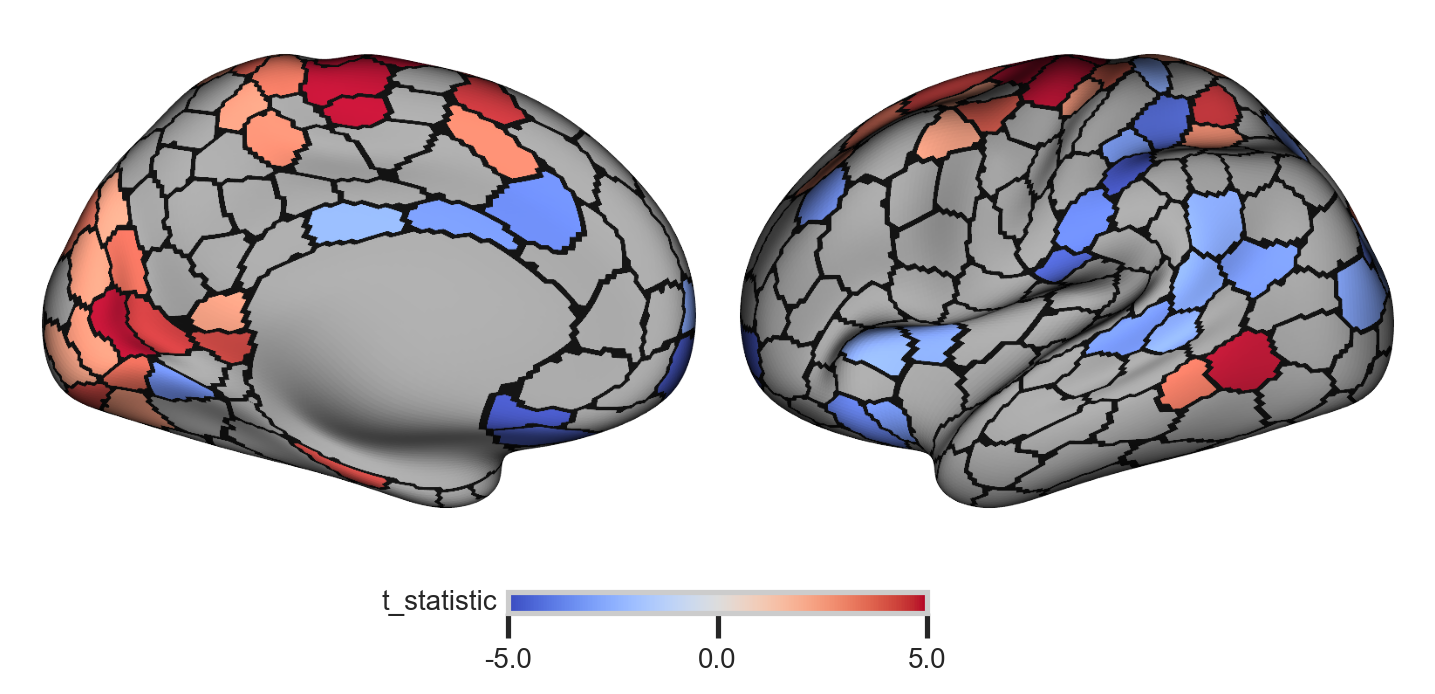

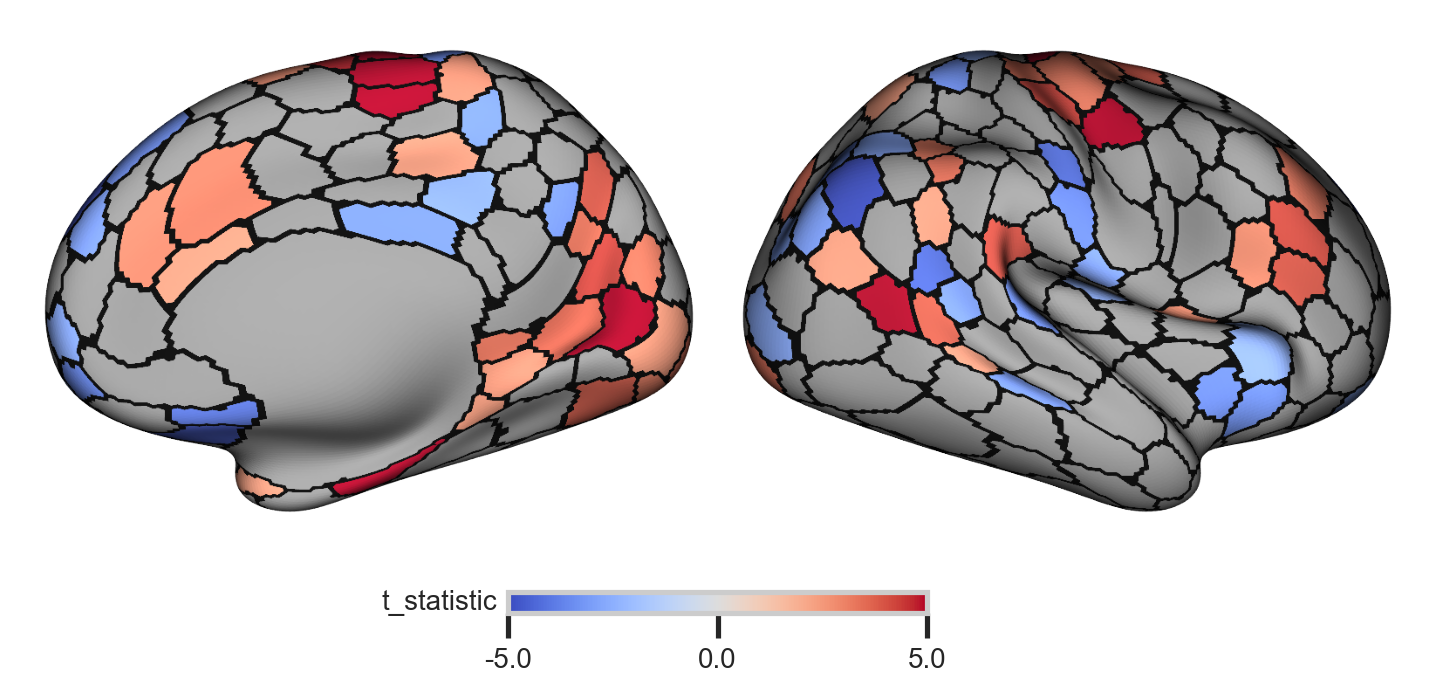

In [ ]:
vmin = -5
vmax = 5

# Corrected loop for plotting each hemisphere independently
for hemi_key, hemi_surf_data, mapped_data, parcellation_data in zip(
    ["left", "right"],  # The key for surfplot's dictionary
    [lh, rh],  # The surface object for the current hemisphere
    [data_lh_mapped, data_rh_mapped],  # The mapped data for the current hemisphere
    [lh_parc, rh_parc],  # The parcellation for the current hemisphere
):
    # ---------------------------------------------------------------------
    # 5.  BUILD THE PLOT
    # ---------------------------------------------------------------------
    pref_surf = {
        "surf_lh": hemi_surf_data if hemi_key == "left" else None,
        "surf_rh": hemi_surf_data if hemi_key == "right" else None,
    }
    p = Plot(
        **pref_surf,  # Unpack the surface dictionary
        views=["medial", "lateral"],  # Show both medial and lateral for this hemi
        size=(800, 300),  # px; change as needed
        zoom=1.6,
        layout="row",  # For a single hemisphere, row is fine
        mirror_views=False,  # Set to False, as we are plotting one hemi at a time
    )

    # ---- main data layer -------------------------------------------------
    # Pass only the data for the current hemisphere
    # The dictionary now contains only one key-value pair for the current hemisphere
    p.add_layer(
        {hemi_key: mapped_data},
        cmap="coolwarm",
        color_range=(vmin, vmax),  # Use symmetric range
        # norm=norm,  # Apply the symmetric normalization
        cbar_label=value_column,
        cbar=True,  # Ensure colorbar is shown for each plot if desired, or handle globally
    )
    # ---- outline layer ---------------------------------------------------
    p.add_layer({hemi_key: parcellation_data}, cmap="gray", as_outline=True, cbar=False)

    fig = p.build(
        # cbar_kws=dict(location="bottom", decimals=2, shrink=0.6)
    )  # Added cbar_kws for better cbar display

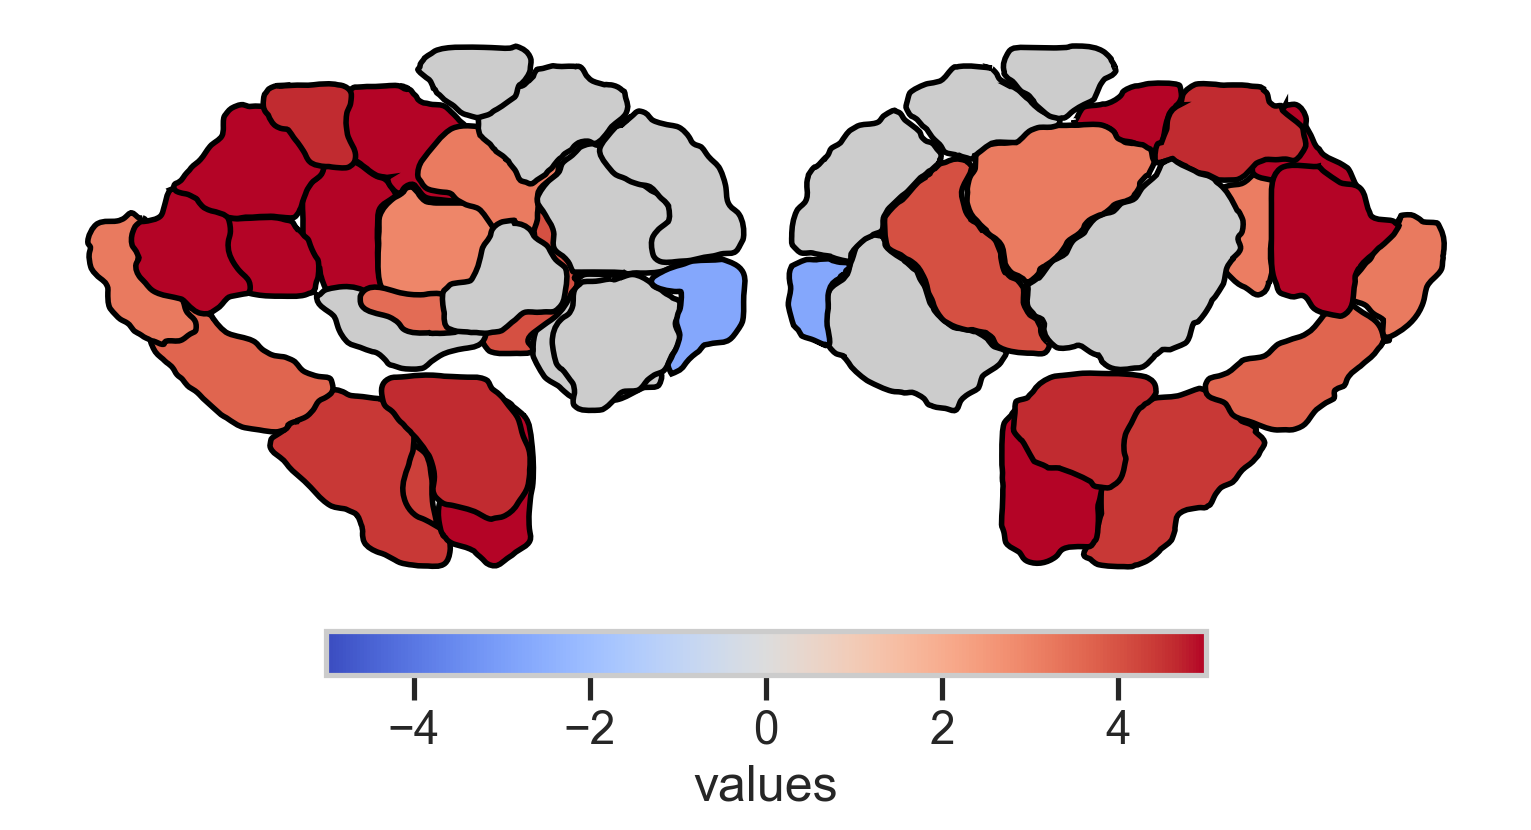

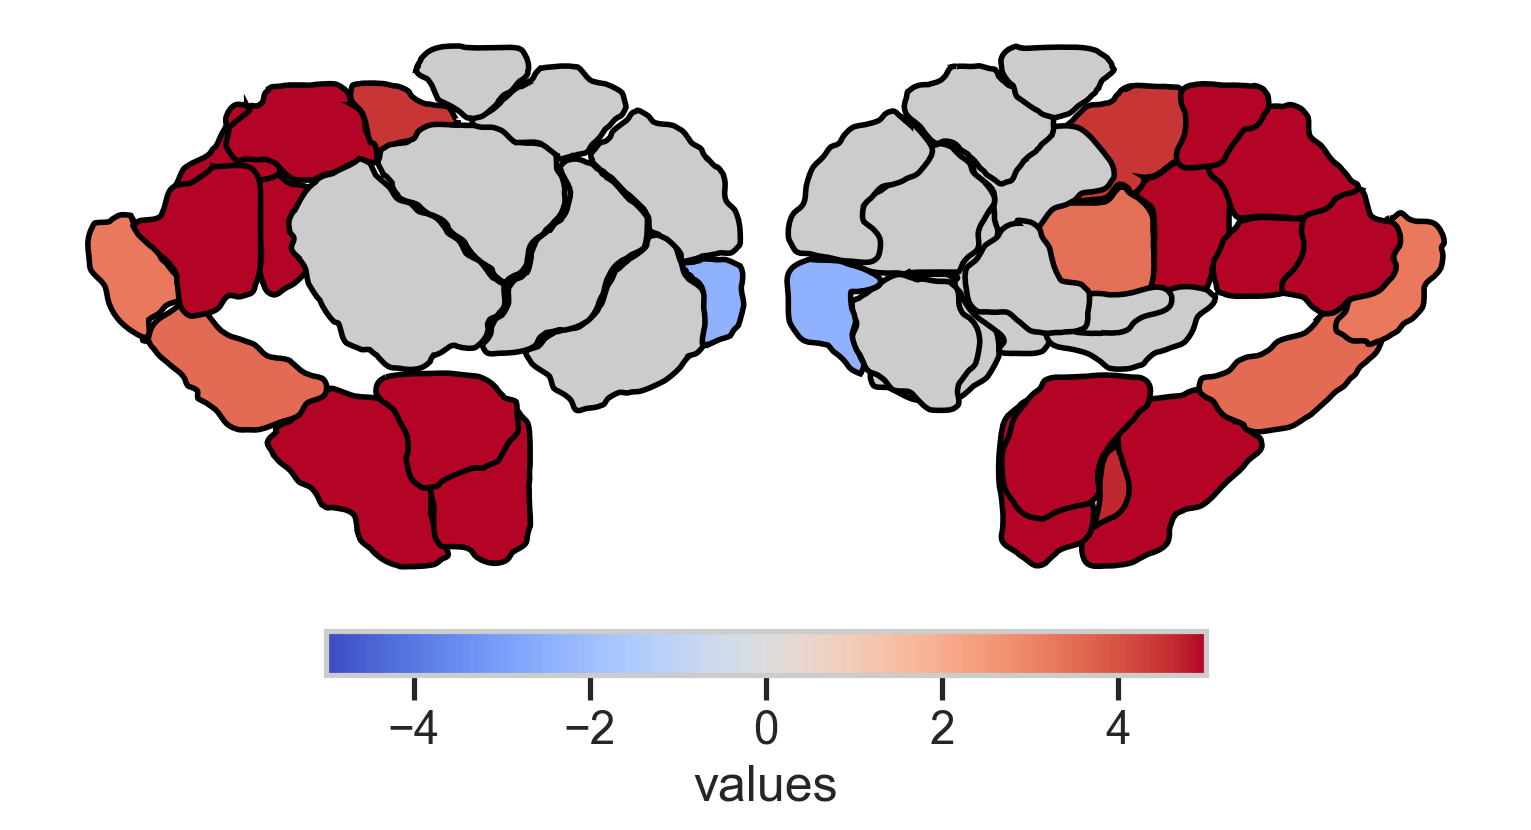

In [ ]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L", "R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        cmap="coolwarm",
        line_color="black",
        line_thickness=2,
        vmin=vmin,
        vmax=vmax,
        show_figure=False,
    )

    # save figure
    # savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)